<a href="https://colab.research.google.com/github/LeonMilosevic/home_credit/blob/main/home_credit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Home Credit Default Risk Competition

### Intro

Introduction: \

https://www.kaggle.com/c/home-credit-default-risk/overview

In Home Credit Default Risk Competition we need to make a model, that will give us a probability that the given client repays the loan. This should help the business decide if they should or should not proivde financial loan to a given customer.

Problem:

It is a binary classification problem:
- Will repay the loan = 0
- Will not repay the loan = 1

Evaluation Criteria:

Based on the requirements of the competition, we will need to evaluate our models on ***roc_auc_score*** metric.

Data:

- application_{train|test}.csv (main file)
- bureau.csv
- bureau_balance.csv
- POS_CASH_balance.csv
- credit_card_balance.csv
- previous_application.csv
- installments_payments.csv
- HomeCredit_columns_description.csv

Approach:
- Explore the data of application_train
- Create baseline model
- Improve model with feature engineering
- Explore other files
- Add usefull features from other files
- Test models on new features
- Feature Engineering


Imports

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno
from scipy import stats

from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder

from sklearn.impute import SimpleImputer

from sklearn.model_selection import RandomizedSearchCV

Files

In [ ]:
app_train = pd.read_csv('application_train.csv')

In [ ]:
app_train.shape

(307511, 122)

In [ ]:
app_train.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Custom Functions

In [ ]:
def check_missing_values(df: pd.DataFrame) -> pd.DataFrame:
  """Checks for missing values in the dataframe

    Args:
        df (pd.DataFrame): DataFrame to be scanned for missing values
    Returns:
        Dataframe of features that are mostly missing with percentage and total count
  """
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)

  return pd.concat([total, percent], axis=1, keys=['total', 'percent'])

def chi_test_missing_data(cols: list, df: pd.DataFrame) -> list:
  """Performs a chi test on given columns

    Args:
        cols (list) : list of columns to be tested
        df (pd.DataFrame): DataFrame to be copied
    Returns:
        p_results (list) : list of p_values in order of columns given
  """
  p_results = []

  for col in cols:
    df_temp = df.copy()

    df_temp['has_missing_column_test'] = 0
    df_temp.loc[df_temp[col].isnull(), 'has_missing_column_test'] = 1

    chi_test = stats.chi2_contingency(pd.crosstab(df_temp.has_missing_column_test, df_temp.TARGET))

    p_results.append(chi_test[1])
  
  return p_results

In [ ]:
model_tracking = pd.DataFrame(columns=['model', 
                                 'feature_eng', 
                                 'params_used', 
                                 'values_used', 
                                 'roc_auc_score_train', 
                                 'roc_auc_score_validation', 
                                 'roc_auc_cv'])

### Missing Values

In [ ]:
missing_values = check_missing_values(app_train)
missing_values[:50]

,total,percent
COMMONAREA_MEDI,214865,0.698723
COMMONAREA_AVG,214865,0.698723
COMMONAREA_MODE,214865,0.698723
NONLIVINGAPARTMENTS_MODE,213514,0.694330
NONLIVINGAPARTMENTS_MEDI,213514,0.694330
NONLIVINGAPARTMENTS_AVG,213514,0.694330
FONDKAPREMONT_MODE,210295,0.683862
LIVINGAPARTMENTS_MEDI,210199,0.683550
LIVINGAPARTMENTS_MODE,210199,0.683550
LIVINGAPARTMENTS_AVG,210199,0.683550


In [ ]:
missing_values[50:70]

,total,percent
EXT_SOURCE_3,60965,0.198253
AMT_REQ_CREDIT_BUREAU_QRT,41519,0.135016
AMT_REQ_CREDIT_BUREAU_YEAR,41519,0.135016
AMT_REQ_CREDIT_BUREAU_WEEK,41519,0.135016
AMT_REQ_CREDIT_BUREAU_MON,41519,0.135016
AMT_REQ_CREDIT_BUREAU_DAY,41519,0.135016
AMT_REQ_CREDIT_BUREAU_HOUR,41519,0.135016
NAME_TYPE_SUITE,1292,0.004201
OBS_30_CNT_SOCIAL_CIRCLE,1021,0.003320
OBS_60_CNT_SOCIAL_CIRCLE,1021,0.003320


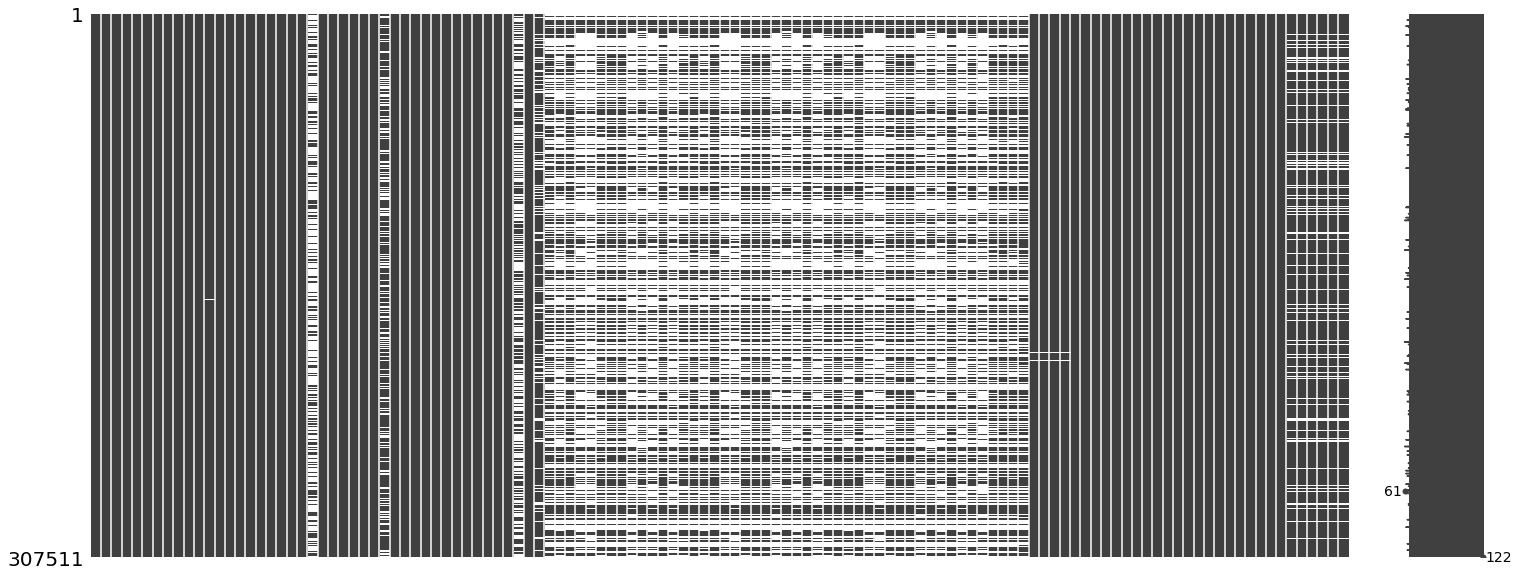

In [ ]:
msno.matrix(app_train)

**Missing Data Conclusions**: \
- According to Docs, missing values occured due to clients/clerks not filling them in, that can be either to clients not having an apartment or a house, or not having an apartment but having a house, or the opposite. It can also be due to not finding relevance in filling in those values. At this moment there is no way of determining if the client owns a house or an apartment and we cannot impute or flag the values with certainty. This is something we need to keep in mind for feature eng.

- Most of the data that has high percentage of missing values is house/apartment information
- OWN_CAR_AGE
- OCCUPATION_TYPE
- EXT_SOURCE_X comes from external source
- AMT_REQ_X did the client previously applied for a loan or not
- the rest is a very small percentage so we will impute it with a median value

AMT_REQ_X, is this due to the clients never previously applied? Check it against the columns that are indicating has the client priviously applied

###### Housing/Apartment missing values

We will use Chi-Square test do determain if there is a difference between clients who did not fill in housing/apartment values and clients who did.

H0: there is no difference between two groups \
H1: there is a difference between two groups \
Statistical Significance: 0.05 \

If there is a difference between two groups, we will add a flag feature to tell us weather the person has filled in apartment discription or not.


**Approach**: \
After consulting the documentation, there are 47 features describing the housing/apartment. \

We can assume that clients who own a house could've skipped filling in values for apartment and vice versa, therefore we shouldn't check if a client didn't fill in 47 variables, we could lower the threshold to 35 since there are at least 9 variables that are indicating that the variable is only from apartment domain. 


In [ ]:
non_housing_missing_features = ['OWN_CAR_AGE',
                                'EXT_SOURCE_1',
                                'OCCUPATION_TYPE']

housing_missing_features = list(set(missing_values[:50].index.tolist()) - set(non_housing_missing_features))

In [ ]:
chi_test_data = app_train.copy()

chi_test_data['has_missing_housing_info'] = 1
chi_test_data.loc[chi_test_data[housing_missing_features].isnull().sum(axis=1) < 35, 'has_missing_housing_info'] = 0
chi_test_data['has_missing_housing_info'].value_counts(normalize=True)

0    0.50179
1    0.49821
Name: has_missing_housing_info, dtype: float64

In [ ]:
pd.crosstab(chi_test_data.has_missing_housing_info, chi_test_data.TARGET)

TARGET,0,1
has_missing_housing_info,,
0,143556,10750
1,139130,14075


In [ ]:
chi_test = stats.chi2_contingency(pd.crosstab(chi_test_data.has_missing_housing_info, chi_test_data.TARGET))
p = chi_test[1]
if p < 0.05:
  print(p, " => reject H0")
else:
  print(p, " => fail to reject H0")

5.176020966832745e-113  => reject H0


Given that P value is less then our significance threshold , we can reject the null hypothesis saying that there is no difference between clients who fill in information, and clients who skip filling in information.

###### OWN_CAR_AGE variable

We will check if own_car_age was skipped due to the client not owning a car.

In [ ]:
app_train['OWN_CAR_AGE'].isnull().sum()

202929

In [ ]:
app_train[app_train['FLAG_OWN_CAR'] == 'N'].shape

(202924, 122)

In [ ]:
app_train[(app_train['FLAG_OWN_CAR'] == 'N') & (app_train['OWN_CAR_AGE'].isnull())].shape

(202924, 122)

In [ ]:
own_car_age_show = {'own_car_age_missing': [202929], 
                    'dont_own_car': [202924], 
                    'dont_own_car_and_own_car_age_missing': [202924], 
                    'own_car_and_car_age_missing': [6]}
own_car_age_df = pd.DataFrame(data=own_car_age_show)
own_car_age_df

,own_car_age_missing,dont_own_car,dont_own_car_and_own_car_age_missing,own_car_and_car_age_missing
0,202929,202924,202924,6


This is an interesting finding, all the clients that don't own a car have missing values for OWN_CAR_AGE variable. There are 6 clients who have a car but haven't filled in the OWN_CAR_AGE. 

###### OCCUPATION_TYPE, EXT_SOURCE_X variables

Lets us do the same test as with housing/apartment missing values, to know if we should flag the missing values in occupation. \

H0: there is no difference between two groups \
H1: there is a difference between two groups \
Statistical Significance: 0.05 \



In [ ]:
p_values = chi_test_missing_data(['OCCUPATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], app_train)

for p in p_values:
  if p < 0.05:
    print(p, " => reject H0")
  else:
    print(p, " => fail to reject H0")

4.804746491614818e-102  => reject H0
5.139197205071727e-25  => reject H0
0.911047427710317  => fail to reject H0
4.8894679928311235e-36  => reject H0


#### Conclusion: 
**Appartment/Housing**: Reject the null hypothesis. \

**own_car_age**: There is a correlation between a client not owning a car and having NaN in own_car_age. \

**OCCUPATION_TYPE**: Reject the null hypothesis. \

**EXT_SOURCE_X**: \
**EXT_SOURCE_1**: reject the null hypothesis \
**EXT_SOURCE_2**: fail to reject the null hypothesis \
**EXT_SOURCE_3**: reject the null hypothesis \

**AMT_REQ_X**: We will deal with this after we start using different datasets, since we will be able to find information about it from different data.

### EDA

In [ ]:
app_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,...,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,...,0.149213,0.225897,0.231625,0.067169,0.101954,0.108607,0.008651,0.028236,0.102547,1.422245,0.143421,1.405292,0.100049,-962.858788,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,11.944812,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.910682,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,0.211062,1.910602e-01,0.194844,0.10824,0.082438,0.059223,0.113280,0.076036,0.134576,0.100049,0.144641,...,0.100368,0.145067,0.161934,0.082167,0.093642,0.112260,0.047415,0.070166,0.107462,2.400989,0.446698,2.379803,0.362291,826.808487,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.054110,

Looking at the Train Data briefly: \

We can see our target variable, it contains 0 and 1 values, with a mean of 0.08 and we can interpret that as a high class imbalance, we should explore it more.

There are encoded values with 0-1, we should consult documentation a bit later when we explore each feature more.

We can as well see drastic difference between max value of some features, we should consider scaling features.

##### Explore target

In [ ]:
app_train['TARGET'].value_counts(normalize=True)

0    0.919271
1    0.080729
Name: TARGET, dtype: float64

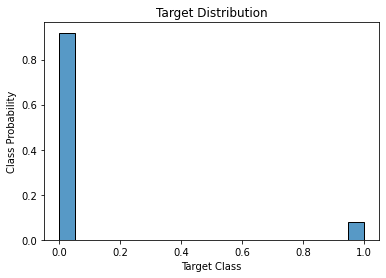

In [ ]:
ax = sns.histplot(app_train['TARGET'], stat='probability')
ax.set(xlabel="Target Class", ylabel='Class Probability', title="Target Distribution")
plt.show()

We can see that the class is highly imbalanced, meaning that there are more people who payed back the loan, rather than the ones who did not. We should keep in mind when performing cross-validation, to use Stratified K-Fold to keep the ratio of values in each fold. As well we can try SMOTE to make the value balanced.

##### Explore Categorical vars

In [ ]:
app_train[app_train['NAME_FAMILY_STATUS']=='Unknown'].shape

(2, 122)

In [ ]:
cat_vars = ['NAME_CONTRACT_TYPE',
            'CODE_GENDER',
            'FLAG_OWN_CAR',
            'FLAG_OWN_REALTY',
            'CNT_CHILDREN',
            'NAME_TYPE_SUITE',
            'NAME_INCOME_TYPE',
            'NAME_EDUCATION_TYPE',
            'NAME_FAMILY_STATUS',
            'NAME_HOUSING_TYPE',
            'OWN_CAR_AGE',
            'FLAG_MOBIL',
            'FLAG_EMP_PHONE',
            'FLAG_WORK_PHONE',
            'FLAG_CONT_MOBILE',
            'FLAG_PHONE',
            'FLAG_EMAIL',
            'OCCUPATION_TYPE',
            'CNT_FAM_MEMBERS',
            'REGION_RATING_CLIENT',
            'REGION_RATING_CLIENT_W_CITY',
            'WEEKDAY_APPR_PROCESS_START',
            'HOUR_APPR_PROCESS_START',
            'REG_REGION_NOT_LIVE_REGION',
            'REG_REGION_NOT_WORK_REGION',
            'LIVE_REGION_NOT_WORK_REGION',
            'REG_CITY_NOT_LIVE_CITY',
            'REG_CITY_NOT_WORK_CITY',
            'LIVE_CITY_NOT_WORK_CITY',
            'ORGANIZATION_TYPE',
            'FONDKAPREMONT_MODE',
            'HOUSETYPE_MODE',
            'WALLSMATERIAL_MODE',
            'EMERGENCYSTATE_MODE',
            'OBS_30_CNT_SOCIAL_CIRCLE',
            'DEF_30_CNT_SOCIAL_CIRCLE',
            'OBS_60_CNT_SOCIAL_CIRCLE',
            'DEF_60_CNT_SOCIAL_CIRCLE',
            'FLAG_DOCUMENT_2',
            'FLAG_DOCUMENT_3',
            'FLAG_DOCUMENT_4',
            'FLAG_DOCUMENT_5',
            'FLAG_DOCUMENT_6',
            'FLAG_DOCUMENT_7',
            'FLAG_DOCUMENT_8',
            'FLAG_DOCUMENT_9',
            'FLAG_DOCUMENT_10',
            'FLAG_DOCUMENT_11',
            'FLAG_DOCUMENT_12',
            'FLAG_DOCUMENT_13',
            'FLAG_DOCUMENT_14',
            'FLAG_DOCUMENT_15',
            'FLAG_DOCUMENT_16',
            'FLAG_DOCUMENT_17',
            'FLAG_DOCUMENT_18',
            'FLAG_DOCUMENT_19',
            'FLAG_DOCUMENT_20',
            'FLAG_DOCUMENT_21',
            'AMT_REQ_CREDIT_BUREAU_HOUR',
            'AMT_REQ_CREDIT_BUREAU_DAY',
            'AMT_REQ_CREDIT_BUREAU_WEEK',
            'AMT_REQ_CREDIT_BUREAU_MON',
            'AMT_REQ_CREDIT_BUREAU_QRT',
            'AMT_REQ_CREDIT_BUREAU_YEAR',
]

In [ ]:
app_train['CODE_GENDER'].value_counts(normalize=True)

F    0.658352
M    0.341648
Name: CODE_GENDER, dtype: float64

In [ ]:
app_train.loc[app_train[app_train['CODE_GENDER'] == 'XNA'].index, 'CODE_GENDER'] = np.nan

Refrence categorical_variables.csv for more info

##### Explore Continuous vars

In [ ]:
continuous_vars = [item for item in app_train.columns.tolist() if item not in cat_vars]
len(continuous_vars[2:])

56

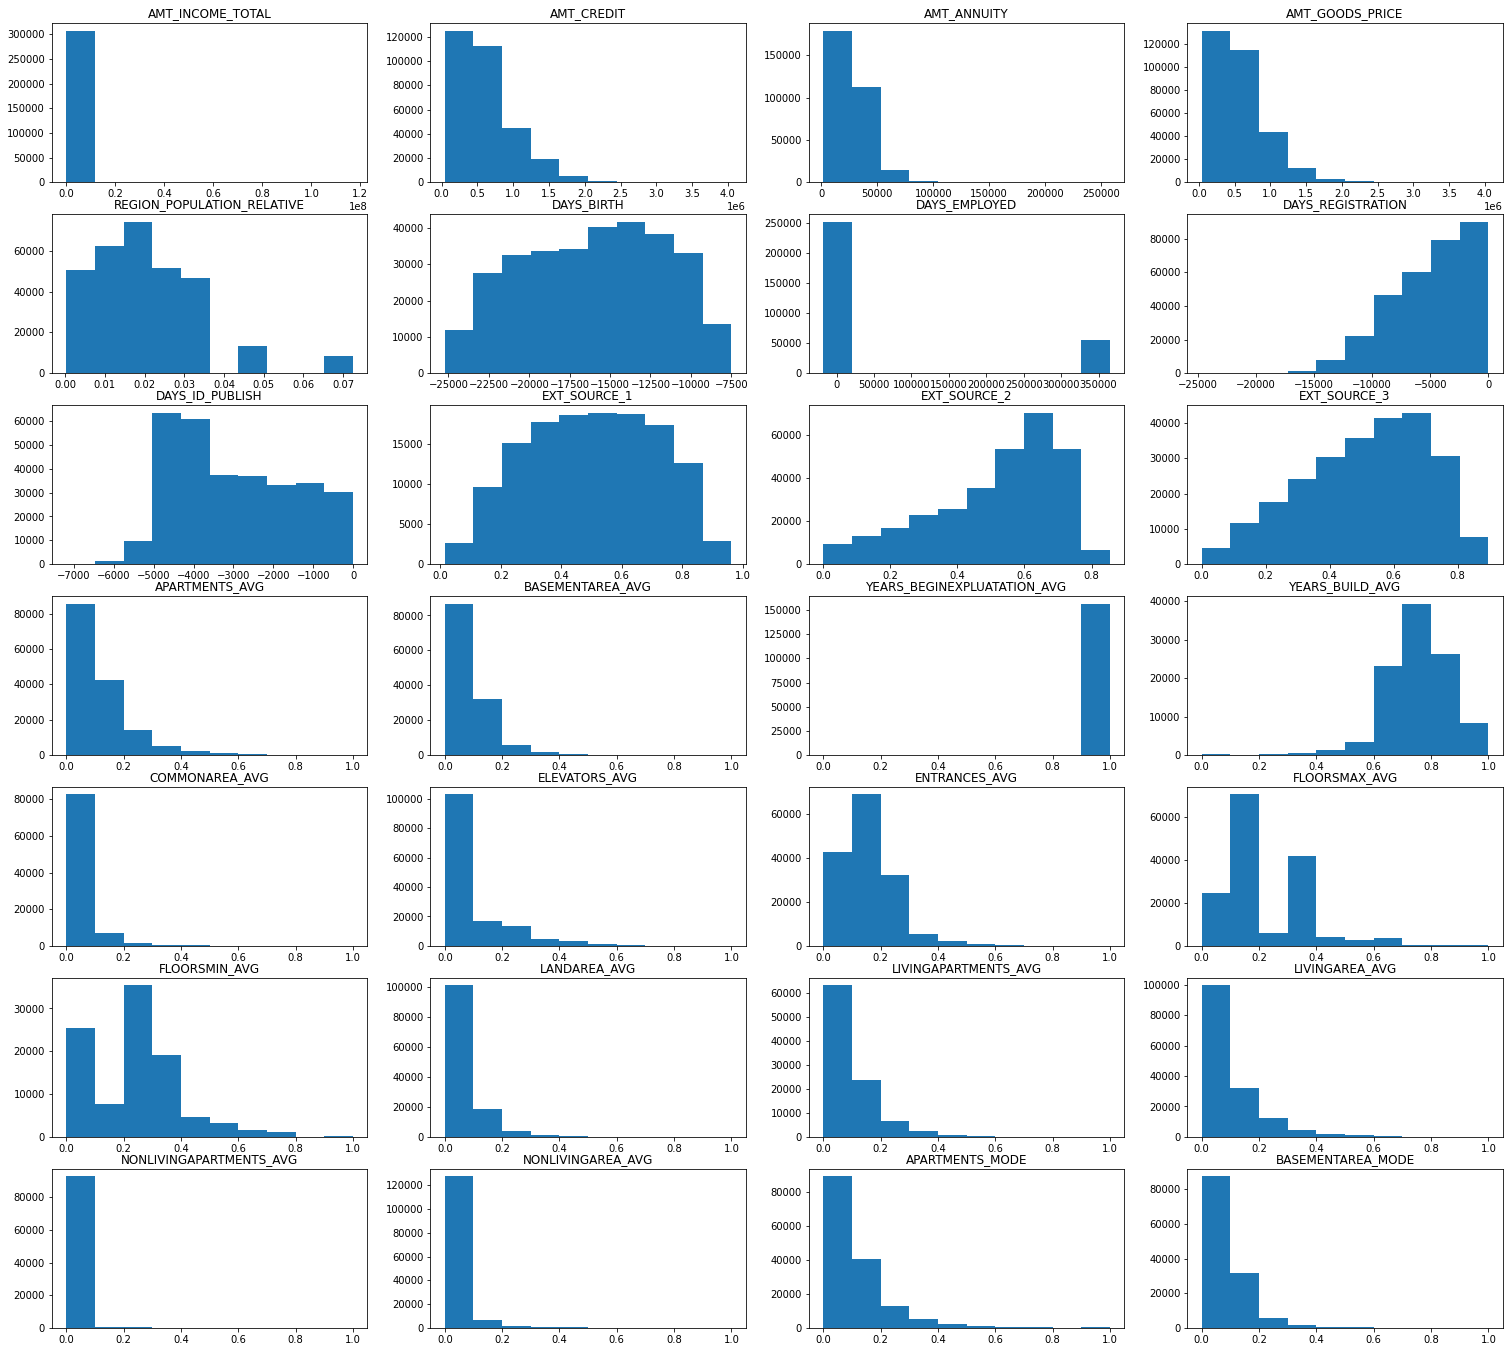

In [ ]:
plt.figure(figsize=(26, 24))
for i, col in enumerate(continuous_vars[2:30]):
    plt.subplot(7, 4, i + 1)
    plt.hist(app_train[col])
    plt.title(col)

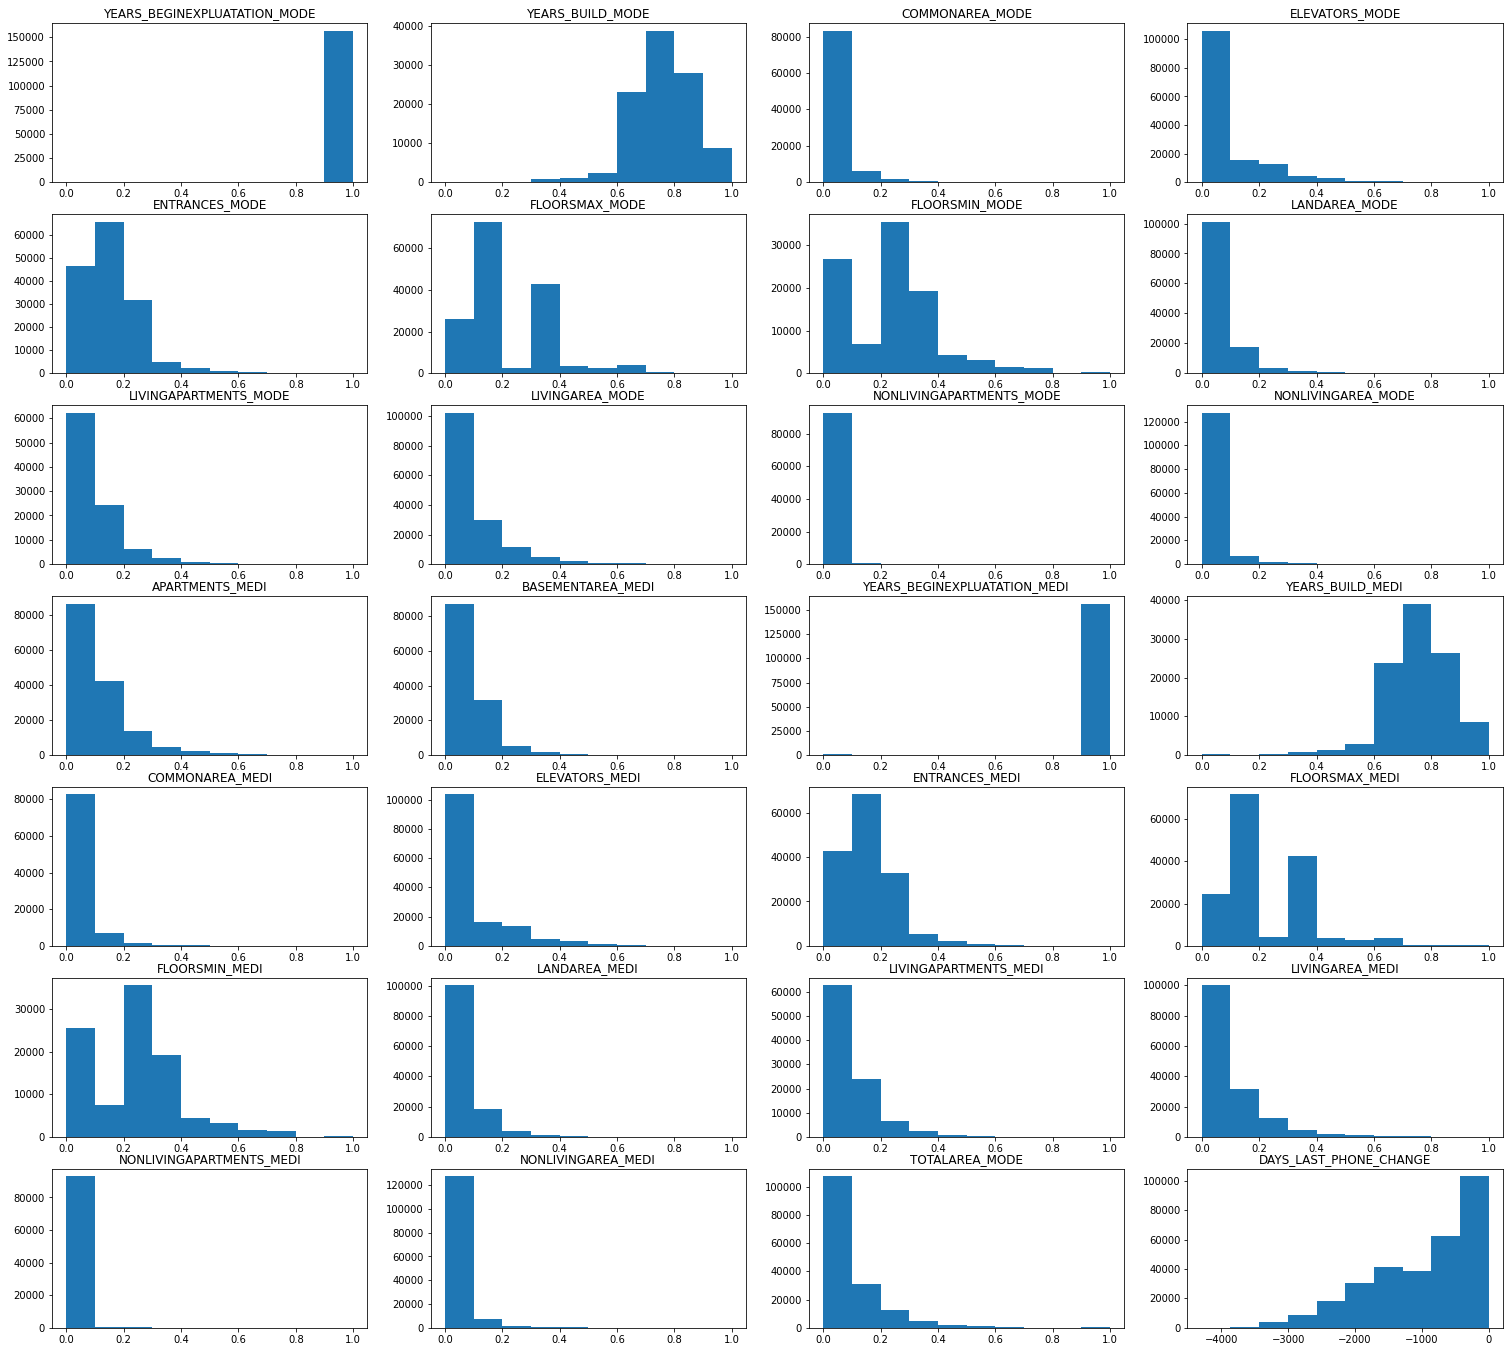

In [ ]:
plt.figure(figsize=(26, 24))
for i, col in enumerate(continuous_vars[30:]):
    plt.subplot(7, 4, i + 1)
    plt.hist(app_train[col])
    plt.title(col)

Cols to explore more:
- DAYS_EMPLOYED (seems to have some discontinuity, we need to check those)


###### DAYS_EMPLOYED

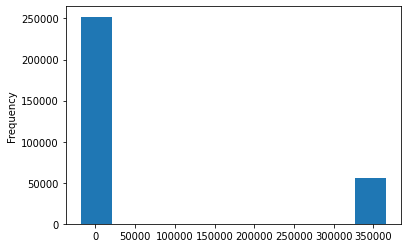

In [ ]:
app_train['DAYS_EMPLOYED'].plot.hist()

In [ ]:
app_train[app_train['DAYS_EMPLOYED'] > 0].shape

(55374, 122)

In [ ]:
app_train[app_train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].unique()

array([365243])

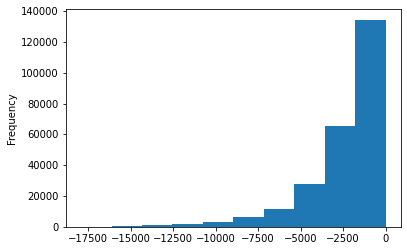

In [ ]:
app_train[app_train['DAYS_EMPLOYED'] <= 0]['DAYS_EMPLOYED'].plot.hist()

Values above 0 have a fixed value of 365243. \

We will check if there is a difference between clients with fixed value and those below 0 regarding TARGET variable.

In [ ]:
days_employed_chi_test = app_train.copy()
days_employed_chi_test['days_employed_anomaly'] = 1

days_employed_chi_test.loc[days_employed_chi_test['DAYS_EMPLOYED'] <= 0, 'days_employed_anomaly'] = 0
days_employed_chi_test['days_employed_anomaly'].value_counts(normalize=True)

0    0.819928
1    0.180072
Name: days_employed_anomaly, dtype: float64

H0: there is no difference between two groups \
H1: there is a difference between two groups \
Statistical Significance: 0.05 \

In [ ]:
chi_test_days_employed = stats.chi2_contingency(pd.crosstab(days_employed_chi_test.days_employed_anomaly, days_employed_chi_test.TARGET))
p = chi_test_days_employed[1]
if p < 0.05:
  print(p, " => reject H0")
else:
  print(p, " => fail to reject H0")

2.362426759854694e-143  => reject H0


Our p is close to 0, so we can reject the null hypothesis. \

We can flag the values, replace fixed value with a missing value and impute with median, or leave as is and just flag it with a binary feature.

###### DAYS_BIRTH

In [ ]:
cols = ['DAYS_BIRTH', 'DAYS_ID_PUBLISHED', '']

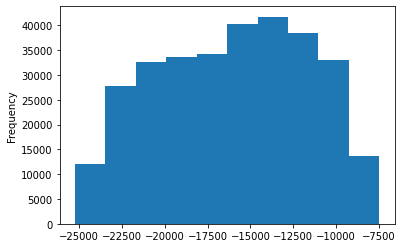

In [ ]:
app_train['DAYS_BIRTH'].plot.hist()

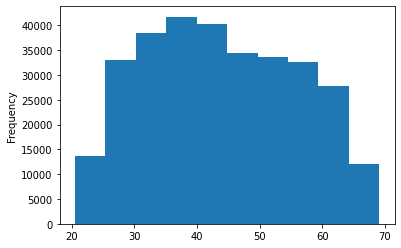

In [ ]:
client_age = app_train['DAYS_BIRTH'] / -365
client_age.plot.hist()

It looks like clients age are between 20-70 years old.

###### Outliers

In [ ]:
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(n_estimators = 10000, random_state = 1)
iforest_predict = iforest.fit_predict(app_train)

ValueError: ignored

In [ ]:
z = np.abs(stats.zscore(app_train[continuous_vars[2:]]))
outliers = np.where(z > 3)

app_train.loc[outliers[0]]['TARGET'].value_counts()

0    12349
1      521
Name: TARGET, dtype: int64

In [ ]:
not_outliers = [item for item in app_train.index.tolist() if item not in outliers[0]]

In [ ]:
app_train.loc[not_outliers]['TARGET'].value_counts()

0    270953
1     24317
Name: TARGET, dtype: int64

In [ ]:
chi_test_outliers = stats.chi2_contingency(pd.crosstab(df_temp.has_missing_column_test, df_temp.TARGET))

### Data Encoding

We will encode categorical vars with one-hot encoding, binary variables will be encoded by dropping the extra column 

In [ ]:
binary_vars = ['NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
non_binary_vars = ['NAME_TYPE_SUITE','NAME_INCOME_TYPE' ,'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE']

In [ ]:
non_binary_baseline = ['NAME_TYPE_SUITE','NAME_INCOME_TYPE' ,'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']

### Baseline Model

Preprocessing: \

For the baseline model, we will remove all the columns with more than 10% of missing data, the rest missing data we will drop. \

In [ ]:
baseline_data = app_train.copy()

missing_cols = missing_values[missing_values['percent'] > 0.1].index.tolist()
baseline_data = baseline_data.drop(missing_cols, axis=1)

baseline_data = baseline_data.dropna()

x_train, x_val, y_train, y_val = train_test_split(baseline_data.drop(['SK_ID_CURR', 'TARGET'], axis=1),
                                                  baseline_data['TARGET'],
                                                  test_size=0.2,
                                                  random_state=RANDOM_STATE,
                                                  stratify=baseline_data['TARGET'])

In [ ]:
RANDOM_STATE = 42

column_encoder = ColumnTransformer(
    [
     ('ohe_drop_first', OneHotEncoder(drop='first'), binary_vars),
     ('ohe_keep_all', OneHotEncoder(), non_binary_baseline)
    ]
)

In [ ]:
gbc = GradientBoostingClassifier(
    random_state=RANDOM_STATE
)

gbc_pipe = Pipeline(
    [
      ('encoder', column_encoder),
      ('model', gbc)
    ]
)

gbc_pipe.fit(x_train, y_train)
print(roc_auc_score(y_train, gbc_pipe.predict_proba(x_train)[:, 1]), 'train')
print(roc_auc_score(y_val, gbc_pipe.predict_proba(x_val)[:, 1]), 'validation')

0.6237908818579256 train
0.6096483296728562 validation


In [ ]:
gb_base_results = {
    'model': 'GB', 
    'feature_eng': np.nan,
    'params_used': 'default', 
    'values_used': 'default', 
    'roc_auc_score_train': 0.6237908818579256,
    'roc_auc_score_validation': 0.6096483296728562,
    'roc_auc_score_cv': np.nan}

model_tracking.loc[len(model_tracking)] = gb_base_results

In [ ]:
xgbc = XGBClassifier(
    random_state=RANDOM_STATE
)

xgbc_pipe = Pipeline(
    [
      ('encoder', column_encoder),
      ('model', xgbc)
    ]
)

xgbc_pipe.fit(x_train, y_train)
print(roc_auc_score(y_train, xgbc_pipe.predict_proba(x_train)[:, 1]), 'train')
print(roc_auc_score(y_val, xgbc_pipe.predict_proba(x_val)[:, 1]), 'validation')

0.6226229831342591 train
0.6089697219114452 validation


In [ ]:
xgb_base_results = {
    'model': 'XGB', 
    'feature_eng': np.nan,
    'params_used': 'default', 
    'values_used': 'default', 
    'roc_auc_score_train': 0.6226229831342591,
    'roc_auc_score_validation': 0.6089697219114452,
    'roc_auc_score_cv': np.nan}

model_tracking.loc[len(model_tracking)] = xgb_base_results

In [ ]:
cbc = CatBoostClassifier(
    random_seed=42,
)

cbc_pipe = Pipeline(
    [
      ('encoder', column_encoder),
      ('model', cbc)
    ]
)

cbc_pipe.fit(x_train, y_train)

In [ ]:
roc_auc_score(y_val, cbc_pipe.predict_proba(x_val)[:, 1])

0.5996382359360599

In [ ]:
model_tracking

,model,feature_eng,params_used,values_used,roc_auc_score_train,roc_auc_score_validation,roc_auc_cv
0,GB,NaN,default,default,0.623791,0.609648,NaN
1,XGB,NaN,default,default,0.622623,0.608970,NaN


### Feature Engineering

Approach: \

- We will use findings from missing value section of the notebook. \

- We will use findings from EDA section of the notebook. \

- We will try to deal with outliers. \

- We will try to create domain knowledge features. \

- We will try combining features. \

- We will use most important features to improve the model

##### Dealing with missing values

Flag clients that have more than 35 missing rows from housing info 

In [117]:
missing_values_data = app_train.copy()

missing_values_data['has_missing_housing_info'] = 1
missing_values_data.loc[missing_values_data[housing_missing_features].isnull().sum(axis=1) < 35, 'has_missing_housing_info'] = 0

missing_cols = missing_values[missing_values['percent'] > 0.1].index.tolist()

missing_values_data = missing_values_data.drop(missing_cols, axis=1)

missing_values_data = missing_values_data.dropna()

x_train, x_val, y_train, y_val = train_test_split(missing_values_data.drop(['SK_ID_CURR', 'TARGET'], axis=1),
                                                  missing_values_data['TARGET'],
                                                  test_size=0.2,
                                                  random_state=RANDOM_STATE,
                                                  stratify=missing_values_data['TARGET'])

In [118]:
gbc = GradientBoostingClassifier(
    random_state=RANDOM_STATE
)

gbc_pipe = Pipeline(
    [
      ('encoder', column_encoder),
      ('model', gbc)
    ]
)

gbc_pipe.fit(x_train, y_train)
print(roc_auc_score(y_train, gbc_pipe.predict_proba(x_train)[:, 1]), 'train')
print(roc_auc_score(y_val, gbc_pipe.predict_proba(x_val)[:, 1]), 'validation')

0.6237908818579256 train
0.6096483296728562 validation
